Imports and Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from tqdm import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline


Data Sampling and Initial Loading

In [7]:
import pandas as pd
import numpy as np

column_names = ["User_ID", "Product_ID", "Category_ID", "Behavior", "Timestamp"]
chunk_size = 10**6  # Adjust based on your memory

# First pass: collect all unique user IDs
user_ids = set()
for chunk in pd.read_csv("UserBehavior.csv", names=column_names, chunksize=chunk_size):
    user_ids.update(chunk["User_ID"].unique())

user_ids = list(user_ids)
np.random.seed(42)
sampled_user_ids = np.random.choice(user_ids, size=int(0.05 * len(user_ids)), replace=False)
sampled_user_ids_set = set(sampled_user_ids)

# Second pass: filter rows for sampled users
sampled_chunks = []
for chunk in pd.read_csv("UserBehavior.csv", names=column_names, chunksize=chunk_size):
    sampled_chunk = chunk[chunk["User_ID"].isin(sampled_user_ids_set)]
    sampled_chunks.append(sampled_chunk)

df_5M = pd.concat(sampled_chunks, ignore_index=True)

# Print dataset info
print(f"There are in total {len(df_5M)} records in the sampled dataset.")
print(f"There are in total {df_5M['User_ID'].nunique()} unique users in the sampled dataset.")
print(f"There are in total {df_5M['Category_ID'].nunique()} categories in the sampled dataset.")
print(f"There are in total {df_5M['Product_ID'].nunique()} products in the sampled dataset.")

# Save sampled data for reuse
df_5M.to_csv("UserBehavior_5M.csv", index=False)

There are in total 5013986 records in the sampled dataset.
There are in total 49399 unique users in the sampled dataset.
There are in total 7490 categories in the sampled dataset.
There are in total 1101876 products in the sampled dataset.


Data Cleaning & Formatting

In [8]:
# Check nulls
print(df_5M.isnull().sum())

# Remove duplicated records
print(f"Duplicated records: {df_5M.duplicated().sum()}")
df_5M.drop_duplicates(inplace=True)
print(f"After duplicate removal: {df_5M.duplicated().sum()}")

# Behavior column rename
behavior_mapping = {'pv': 'PageView', 'buy': 'Buy', 'cart': 'AddToCart', 'fav': 'Favorite'}
df_5M['Behavior'] = df_5M['Behavior'].replace(behavior_mapping)

# Convert Timestamp to datetime
df_5M['Datetime'] = pd.to_datetime(df_5M['Timestamp'], unit='s')

# Filter valid year 2017 only, and date between 2017-11-25 and 2017-12-03
df_5M = df_5M[df_5M['Datetime'].dt.year == 2017]
df_5M = df_5M[(df_5M['Datetime'] >= '2017-11-25 00:00:00') & (df_5M['Datetime'] <= '2017-12-03 23:59:59')]

# Add additional columns
df_5M['Day_of_Week'] = df_5M['Datetime'].dt.day_name()
df_5M['Hour'] = df_5M['Datetime'].dt.hour
df_5M['Date'] = df_5M['Datetime'].dt.date

# Keep Day_of_Week as ordered categorical
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_5M['Day_of_Week'] = pd.Categorical(df_5M['Day_of_Week'], categories=days_order, ordered=True)

print(f"Final cleaned dataset size: {len(df_5M)}")


User_ID        0
Product_ID     0
Category_ID    0
Behavior       0
Timestamp      0
dtype: int64
Duplicated records: 2
After duplicate removal: 0
Final cleaned dataset size: 4952340


Exploratory Data Analysis (EDA)

In [ ]:
# Popular Categories
top_5_categories = df_5M['Category_ID'].value_counts().head(5)
print(top_5_categories)

Category_ID
4756105    244683
4145813    174641
2355072    166973
3607361    157673
982926     156418
Name: count, dtype: int64


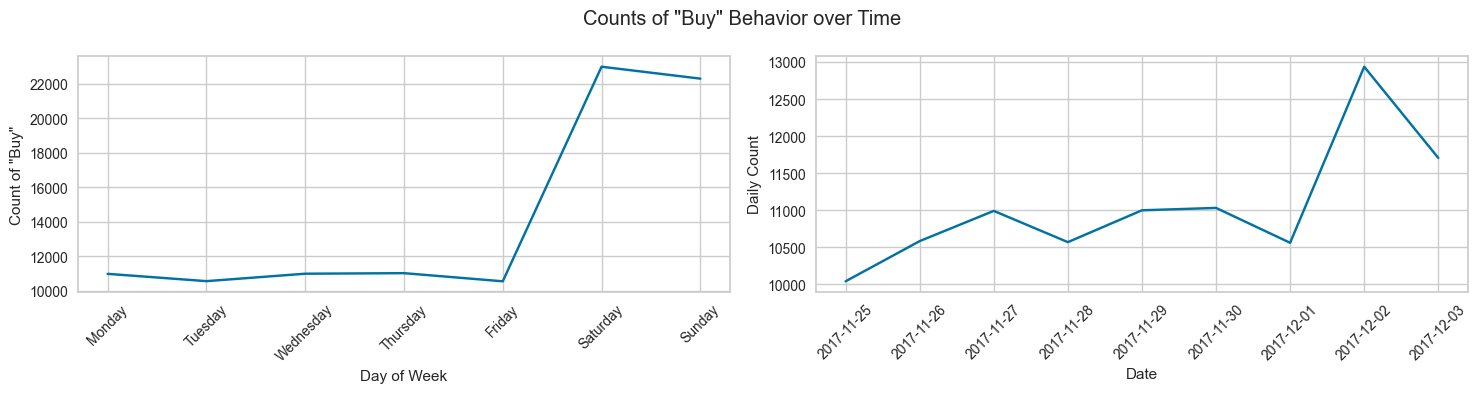

In [10]:
# Buy Behavior Over Time

# Daily buys
buy = df_5M[df_5M['Behavior'] == 'Buy']
buy_count = buy.groupby('Date').size().reset_index(name='count').sort_values('Date')

# Buy count by day of week (ordered)
buy_day_of_week = buy.groupby('Day_of_Week').size().reset_index(name='count')
buy_day_of_week['Day_of_Week'] = pd.Categorical(buy_day_of_week['Day_of_Week'], categories=days_order, ordered=True)
buy_day_of_week = buy_day_of_week.sort_values('Day_of_Week')

# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(buy_day_of_week['Day_of_Week'], buy_day_of_week['count'])
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Count of "Buy"')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(buy_count['Date'], buy_count['count'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Daily Count')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Counts of "Buy" Behavior over Time')
plt.tight_layout()
plt.show()


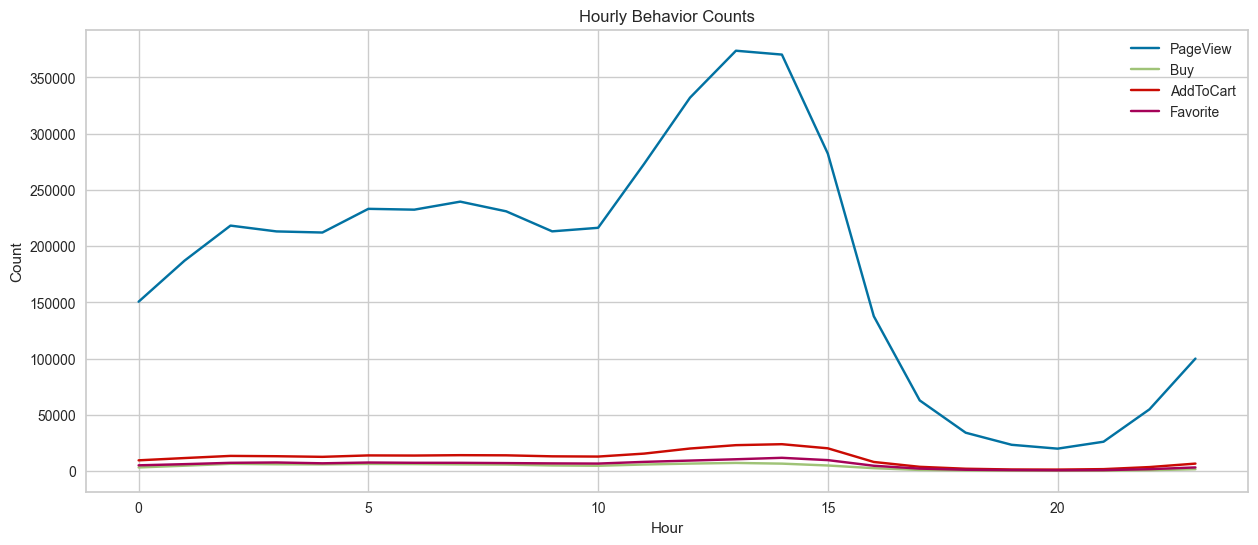

In [11]:
# Hourly behavior counts plot

hourly_behavior = df_5M.groupby(['Hour', 'Behavior']).size().reset_index(name='Behavior_Count')
hourly_behavior_count = hourly_behavior.pivot_table(index='Hour', columns='Behavior', values='Behavior_Count', fill_value=0)
hourly_behavior_count.reset_index(inplace=True)

plt.figure(figsize=(15, 6))
sns.lineplot(data=hourly_behavior_count, x='Hour', y='PageView', label='PageView')
sns.lineplot(data=hourly_behavior_count, x='Hour', y='Buy', label='Buy')
sns.lineplot(data=hourly_behavior_count, x='Hour', y='AddToCart', label='AddToCart')
sns.lineplot(data=hourly_behavior_count, x='Hour', y='Favorite', label='Favorite')
plt.title('Hourly Behavior Counts')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()


Conversion Rate Calculation

In [12]:
conversion = df_5M[df_5M['Behavior'].isin(['Buy', 'PageView'])]
conversion_pb = conversion.groupby('Category_ID')['Behavior'].value_counts().unstack().fillna(0)
conversion_pb = conversion_pb[conversion_pb['PageView'] >= conversion_pb['Buy']]
conversion_pb['Conversion_Rate'] = conversion_pb['Buy'] / (conversion_pb['Buy'] + conversion_pb['PageView'])

# Top 10 categories by Buy count
conversion_10 = conversion_pb.sort_values(by='Buy', ascending=False).head(10)
print(conversion_10)


Behavior        Buy  PageView  Conversion_Rate
Category_ID                                   
1464116      1704.0   34810.0         0.046667
2735466      1687.0   55598.0         0.029449
2885642      1629.0   46676.0         0.033723
4145813      1601.0  158843.0         0.009979
4756105      1475.0  225796.0         0.006490
4801426      1362.0   93934.0         0.014292
982926       1258.0  142944.0         0.008724
4159072       923.0    8982.0         0.093185
2640118       888.0   35348.0         0.024506
1320293       861.0   89361.0         0.009543


Customer Segmentation with RFM and K-Means

In [13]:
# Calculate Recency and Frequency

# Recency
recency = df_5M[df_5M['Behavior'] == 'Buy'].groupby('User_ID', as_index=False)['Date'].max()
recency.columns = ['User_ID', 'LastPurchaseDate']
current_date = recency['LastPurchaseDate'].max()
recency['Recency'] = recency['LastPurchaseDate'].apply(lambda x: (current_date - x).days)

# Frequency
frequency = df_5M[df_5M['Behavior'] == 'Buy'].groupby('User_ID').size().reset_index(name='Frequency')

# Merge into RFM
rfm = recency.merge(frequency, on='User_ID')
rfm.drop(columns=['LastPurchaseDate'], inplace=True)


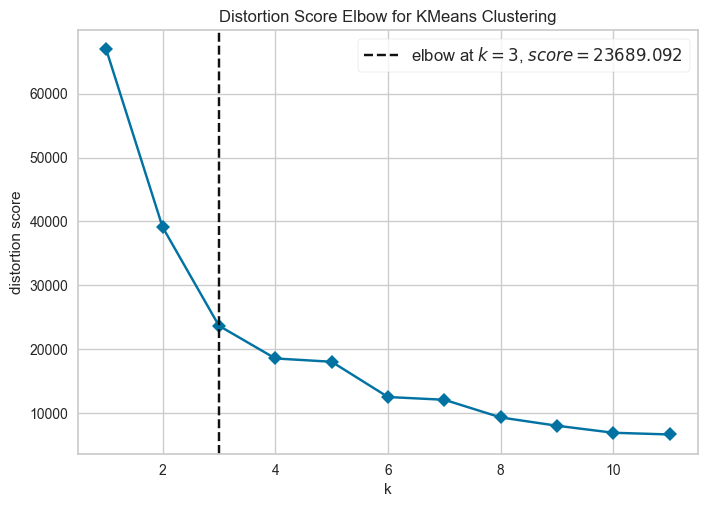

   User_ID  Recency  Frequency  R_score  F_score  Cluster  \
0       16        2          2        3        2        0   
1       20        2          1        3        1        0   
2       68        0          4        4        3        0   
3      132        5          1        1        1        1   
4      151        1          2        4        2        0   

         Customer_Class  
0  Churn Risk Customers  
1  Churn Risk Customers  
2  Churn Risk Customers  
3   Potential Customers  
4  Churn Risk Customers  


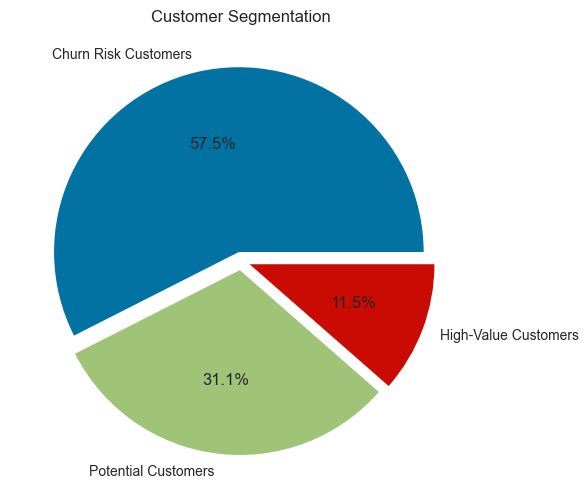

In [14]:
# R, F Scoring and Clustering

quantiles = rfm.quantile(q=[0.25, 0.5, 0.75]).to_dict()

def r_score(x):
    if x <= quantiles['Recency'][0.25]:
        return 4
    elif x <= quantiles['Recency'][0.5]:
        return 3
    elif x <= quantiles['Recency'][0.75]:
        return 2
    else:
        return 1

def f_score(x):
    if x <= quantiles['Frequency'][0.25]:
        return 1
    elif x <= quantiles['Frequency'][0.5]:
        return 2
    elif x <= quantiles['Frequency'][0.75]:
        return 3
    else:
        return 4

rfm['R_score'] = rfm['Recency'].apply(r_score)
rfm['F_score'] = rfm['Frequency'].apply(f_score)

# Clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency']])

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False)
visualizer.fit(rfm_scaled)  
visualizer.show()

# Fit KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

def categorize_customers(row):
    if row['Cluster'] == 0:
        return 'Churn Risk Customers'
    elif row['Cluster'] == 1:
        return 'Potential Customers'
    elif row['Cluster'] == 2:
        return 'High-Value Customers'

rfm['Customer_Class'] = rfm.apply(categorize_customers, axis=1)
print(rfm.head())

# Plot customer class distribution
customer_class = rfm['Customer_Class'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(customer_class, labels=customer_class.index, autopct='%1.1f%%', explode=[0.05]*3)
plt.title('Customer Segmentation')
plt.show()


Predictive Behavior Modeling (LSTM & RNN)

In [15]:
# Data Preparation for Sequences

# Sort by user and datetime
df_5M_time = df_5M.sort_values(by=['User_ID', 'Datetime'])

# Keep only user-product pairs with >= 5 behaviors
behavior_count = df_5M_time.groupby(['Product_ID', 'User_ID']).size().reset_index(name='Behavior_Count')
filtered_bc = behavior_count[behavior_count['Behavior_Count'] >= 5]
df_5M_filtered = df_5M_time.merge(filtered_bc, on=['Product_ID', 'User_ID'])

# Group sequence of behaviors per user
sequence = df_5M_filtered.groupby('User_ID')['Behavior'].apply(list).reset_index(name='Sequence')

# Split dataset
sequence_train, sequence_test = train_test_split(sequence, test_size=0.2, random_state=42)
sequence_val, sequence_test = train_test_split(sequence_test, test_size=0.5, random_state=42)


In [16]:
# Dataset and DataLoader

PADDING_IDX = 4

class UserBehaviorDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.token_to_idx = {'PageView': 0, 'AddToCart': 1, 'Buy': 2, 'Favorite': 3, 'Padding': PADDING_IDX}
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        sequence = self.dataframe.iloc[idx]['Sequence']
        sequence_idx = [self.token_to_idx[action] for action in sequence]
        return torch.tensor(sequence_idx), torch.tensor(len(sequence_idx))

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = torch.tensor(yy)
    xx_pad = torch.nn.utils.rnn.pad_sequence(xx, batch_first=True, padding_value=PADDING_IDX)
    return xx_pad, x_lens

train_dataset = UserBehaviorDataset(sequence_train)
val_dataset = UserBehaviorDataset(sequence_val)
test_dataset = UserBehaviorDataset(sequence_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)


In [17]:
# LSTM Model

class LSTMBehaviorModel(nn.Module):
    def __init__(self, num_tokens, hidden_size=128, num_layers=2):
        super(LSTMBehaviorModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(num_tokens, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_tokens)
    def forward(self, x, x_lens):
        x = self.embed(x)
        packed_x = pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        packed_out, _ = self.lstm(packed_x, (h0, c0))
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.fc(out)
        return out


In [18]:
# Training LSTM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMBehaviorModel(num_tokens=5).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PADDING_IDX, reduction='none').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
num_epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    for x_padded, x_lens in tqdm(train_loader):
        x_padded, x_lens = x_padded.to(device), x_lens.to(device)
        optimizer.zero_grad()
        output = model(x_padded, x_lens)
        loss = criterion(output.view(-1, 5), x_padded.view(-1))
        loss = loss.view(x_padded.size(0), -1).sum(dim=1).mean()
        train_loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_padded, x_lens in val_loader:
            x_padded, x_lens = x_padded.to(device), x_lens.to(device)
            output = model(x_padded, x_lens)
            val_loss = criterion(output.view(-1, 5), x_padded.view(-1))
            val_loss = val_loss.view(x_padded.size(0), -1).sum(dim=1).mean()
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch}: Avg. Validation Loss: {avg_val_loss}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_lstm_model.pth')


100%|██████████| 571/571 [00:50<00:00, 11.29it/s]


Epoch 0: Avg. Validation Loss: 0.008136080364541462


100%|██████████| 571/571 [00:48<00:00, 11.79it/s]


Epoch 1: Avg. Validation Loss: 0.0024157853784143096


100%|██████████| 571/571 [00:47<00:00, 12.04it/s]


Epoch 2: Avg. Validation Loss: 0.001142701168040124


100%|██████████| 571/571 [00:47<00:00, 11.96it/s]


Epoch 3: Avg. Validation Loss: 0.0006465381411544513


100%|██████████| 571/571 [00:49<00:00, 11.62it/s]


Epoch 4: Avg. Validation Loss: 0.00040079120865104615


In [19]:
# Evaluate LSTM Model

model.load_state_dict(torch.load('best_lstm_model.pth'))
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for x_padded, x_lens in test_loader:
        x_padded, x_lens = x_padded.to(device), x_lens.to(device)
        output = model(x_padded, x_lens)
        preds = output.argmax(dim=-1)
        for i, length in enumerate(x_lens):
            all_predictions.append(preds[i, length-1].item())
            all_labels.append(x_padded[i, length-1].item())

accuracy = accuracy_score(all_labels, all_predictions)
print(f"LSTM Test Accuracy: {accuracy}")


LSTM Test Accuracy: 1.0


In [20]:
#  RNN Model (Alternative)

class RNNBehaviorModel(nn.Module):
    def __init__(self, num_tokens, hidden_size=128, num_layers=1):
        super(RNNBehaviorModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(num_tokens, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_tokens)
    def forward(self, x, x_lens):
        x = self.embed(x)
        packed_x = pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        packed_out, _ = self.rnn(packed_x, h0)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.fc(out)
        return out


In [21]:
# Train and Evaluate RNN

model = RNNBehaviorModel(num_tokens=5).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PADDING_IDX, reduction='none').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for x_padded, x_lens in tqdm(train_loader):
        x_padded, x_lens = x_padded.to(device), x_lens.to(device)
        optimizer.zero_grad()
        output = model(x_padded, x_lens)
        loss = criterion(output.view(-1, 5), x_padded.view(-1))
        loss = loss.view(x_padded.size(0), -1).sum(dim=1).mean()
        loss.backward()
        optimizer.step()
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_padded, x_lens in val_loader:
            x_padded, x_lens = x_padded.to(device), x_lens.to(device)
            output = model(x_padded, x_lens)
            val_loss = criterion(output.view(-1, 5), x_padded.view(-1))
            val_loss = val_loss.view(x_padded.size(0), -1).sum(dim=1).mean()
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch}: Avg. Validation Loss: {avg_val_loss}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_rnn_model.pth')

# Evaluate RNN model
model.load_state_dict(torch.load('best_rnn_model.pth'))
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for x_padded, x_lens in test_loader:
        x_padded, x_lens = x_padded.to(device), x_lens.to(device)
        output = model(x_padded, x_lens)
        preds = output.argmax(dim=-1)
        for i, length in enumerate(x_lens):
            all_predictions.append(preds[i, length-1].item())
            all_labels.append(x_padded[i, length-1].item())

accuracy = accuracy_score(all_labels, all_predictions)
print(f"RNN Test Accuracy: {accuracy}")


100%|██████████| 571/571 [00:17<00:00, 33.51it/s]


Epoch 0: Avg. Validation Loss: 0.005851935265430559


100%|██████████| 571/571 [00:13<00:00, 41.80it/s]


Epoch 1: Avg. Validation Loss: 0.0018697245331067178


100%|██████████| 571/571 [00:13<00:00, 41.26it/s]


Epoch 2: Avg. Validation Loss: 0.00090445462572259


100%|██████████| 571/571 [00:14<00:00, 38.34it/s]


Epoch 3: Avg. Validation Loss: 0.0005214435437260868


100%|██████████| 571/571 [00:14<00:00, 39.86it/s]


Epoch 4: Avg. Validation Loss: 0.00032898697039248265
RNN Test Accuracy: 1.0
